In [1]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../../utils/")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb
import requests
import re

import numpy as np
import pandas as pd
from functools import reduce
from collections import Counter

import networkx as nx

import signal

import warnings
warnings.filterwarnings("ignore")

from wiki_intro_scrapper import WikiIntroScrapper
from WikiMultiQuery import wiki_multi_query
from graph_helpers import create_dispersion_df, sort_dict_values, format_categories, compare_categories, rank_order

%aimport wiki_intro_scrapper
%aimport WikiMultiQuery
%aimport graph_helpers

In [142]:
class GraphCreator:

    def __init__(self, entry):
        self.graph = nx.DiGraph()

        self.entry = entry

        wis = WikiIntroScrapper(f"https://en.wikipedia.org/wiki/{entry}")
        wis.parse_intro_links()

        self.intro_nodes = wis.intro_link_titles

        self.visited = {entry}
        self.next_links = []
        
        self.categories = {}
        
        self.redirect_targets = []
        self.redirect_sources = {}
        
        self.query_articles([entry])

        # setup timeout function

        def handle_alarm(signum, frame):
            raise RuntimeError

        signal.signal(signal.SIGALRM, handle_alarm)

    def add_edges(self, articles):
        for article in articles:
            
            self.categories[article['title']] = format_categories([category.split("Category:")[1] for category in article['categories'] if not bool(re.findall(r"(articles)|(uses)|(commons)|(category\:use)", category, re.I))])
            
            self.graph.add_edges_from(
                [(article['title'], link) for link in article['links']])
            self.graph.add_edges_from(
                [(linkhere, article['title']) for linkhere in article['linkshere']])

    def update_edge_weights(self):
        for edge in self.graph.out_edges:
            weight = compare_categories(edge[0], edge[1], self.categories)
            self.graph.add_edge(edge[0], edge[1], weight=weight)
            
        for edge in self.graph.in_edges:
            weight = compare_categories(edge[0], edge[1], self.categories)
            self.graph.add_edge(edge[0], edge[1], weight=weight)
    
    def get_edge_weights(self):
        edge_weights = []
        for edge in self.graph.edges:
            edge_weights.append((edge[0], edge[1], self.graph.get_edge_data(edge[0], edge[1])['weight']))
        
#         for edge in self.graph.in_edges:
#             edge_weights.append((edge[0], edge[1], self.graph.get_edge_data(edge[0], edge[1])['weight']))
        
        return pd.DataFrame(edge_weights, columns=["source_node", "target_node", "edge_weight"]).sort_values("edge_weight", ascending=False).reset_index().drop("index", axis=1)
    
    def plot_graph(self):
        nx.draw(self.graph)
        plt.show()

    def get_shared_categories_with_source(self):
        cat_matches = {}
        for node in self.graph.nodes:
            cat_matches[node] = compare_categories(self.entry, node, self.categories, starting_count=0)
        return sort_dict_values(cat_matches, ['node', 'category_matches_with_source'], 'category_matches_with_source', ascending=False)
            
            
    def get_degrees(self):
        return sort_dict_values(dict(self.graph.degree()), ["node", "degree"], "degree",)

    def get_edges(self):
        in_edges = sort_dict_values(dict(Counter([edge[1] for edge in self.graph.in_edges()])), 
                            ['node', 'in_edges'], "in_edges")
        out_edges = sort_dict_values(dict(Counter([edge[0] for edge in self.graph.out_edges()])), 
                            ["node", 'out_edges'], 'out_edges')

        return in_edges.merge(out_edges, on="node")
    
    def get_centrality(self):
        return sort_dict_values(nx.eigenvector_centrality(self.graph, weight="weight"), ["node", "centrality"], "centrality")

    def get_dispersion(self, comparison_node=None, max_nodes=25_000):
        if not comparison_node:
            comparison_node = self.entry
            
        if max_nodes is None or len(self.graph.nodes) <= max_nodes:
            print("FULL")
            return sort_dict_values(nx.dispersion(self.graph, u=comparison_node), ['node', 'dispersion'], 'dispersion')
        else:
            print("EGO")
            # if the network is too large, perform calculation on ego graph of entry node
            ego = self.create_ego()
            return sort_dict_values(nx.dispersion(ego, u=comparison_node), ['node', 'dispersion'], 'dispersion')

    def get_pageranks(self):
        page_ranks = sorted([(key, value) for key, value in nx.algorithms.link_analysis.pagerank(
            self.graph, weight='weight').items()], key=lambda x: x[1], reverse=True)
        return pd.DataFrame(page_ranks, columns=["node", "page_rank"])

    def get_reciprocity(self):
        return sort_dict_values(nx.algorithms.reciprocity(self.graph, self.graph.nodes), ['node', 'reciprocity'], 'reciprocity')

    def get_adjusted_reciprocity(self):
        r = self.get_reciprocity()
        d = self.get_degrees()

        r_d = r.merge(d, on="node", how="inner")
        r_d['adjusted_reciprocity'] = r_d.reciprocity * r_d.degree

        adjusted_reci = r_d.sort_values("adjusted_reciprocity", ascending=False)
        return adjusted_reci.reset_index().drop(["degree", "reciprocity", "index"], axis=1)
    
    def get_shortes_path(self, source=None, ascending=False):
        if not source:
            source = self.entry
            
        paths = nx.algorithms.shortest_paths.weighted.single_source_dijkstra_path_length(self.graph, source, weight="weight")
        return sort_dict_values(paths, ["node", "shortest_path_length_from_source"], "shortest_path_length_from_source", ascending=ascending)
    
    def get_dominator_counts(self, source=None):
        if not source:
            source = self.entry
            
        dom_dict = nx.algorithms.dominance.immediate_dominators(self.graph, start=source)
        
        dom_counts = {}

        for key, value in dom_dict.items():
            if value in dom_counts:
                dom_counts[value] += 1
            else:
                dom_counts[value] = 1
        for node in self.graph.nodes:
            if not node in dom_counts:
                dom_counts[node] = 0
        
        return sort_dict_values(dom_counts, ['node', 'immediate_dominator_count'], 'immediate_dominator_count')
    
    def get_hits(self):
        hits = nx.algorithms.link_analysis.hits_alg.hits(self.graph, max_iter=1000)
        return (sort_dict_values(hits[1], ['node', 'hits_authority'], 'hits_authority')
                .merge(sort_dict_values(hits[0], ['node', 'hits_hub'], 'hits_hub'), on="node"))
    
    def get_features_df(self, rank=False):
        dfs = []
        if rank:
            dfs.append(rank_order(self.get_degrees(), 'degree', ascending=False))
            dfs.append(rank_order(self.get_shared_categories_with_source(), 'category_matches_with_source', ascending=False))
            dfs.append(self.get_edges())
            dfs.append(rank_order(self.get_centrality(), 'centrality', ascending=True))
            dfs.append(rank_order(self.get_dispersion(), "dispersion", ascending=True))
            dfs.append(rank_order(self.get_pageranks(), "page_rank", ascending=False))
            dfs.append(rank_order(self.get_adjusted_reciprocity(), "adjusted_reciprocity", ascending=False))
            dfs.append(rank_order(self.get_shortes_path(), "shortest_path_length_from_source", ascending=True))
        
        else:
            dfs.append(self.get_degrees())
            dfs.append(self.get_shared_categories_with_source())
            dfs.append(self.get_edges())
            dfs.append(self.get_centrality())
            dfs.append(self.get_dispersion())
            dfs.append(self.get_pageranks())
            dfs.append(self.get_adjusted_reciprocity())
            dfs.append(self.get_shortes_path())
        
        return reduce(lambda left, right: pd.merge(left, right, on="node", how="outer"), dfs)
        
    
    def create_ego(self, node=None):
        if not node:
            node = self.entry

        ego = nx.ego_graph(self.graph, node)
        ego.name = node
        return ego

    def expand_network(self, group_size=10, timeout=10, log_progress=False):

        num_links = len(self.next_links)

        link_group = []

        for i in range(num_links):
            link = self.next_links.pop(0)
            if not link in self.visited:

                link_group.append(link)

                if len(link_group) == group_size or (i == num_links - 1 and len(link_group) > 0):
                    print("{:.2%}".format(i/num_links)) if log_progress else None
                    try:
                        signal.alarm(timeout)
                        self.visited.update(link_group)
                        self.query_articles(link_group)
                        signal.alarm(0)
                        link_group = []
                    except:
                        link_group = []
                        continue
        signal.alarm(0)

    def update_redirects(self, articles):
        for article in articles:
            if article.get("redirects"):
                self.redirect_targets.append(article["title"])
                for redirect in article["redirects"]:
                    self.redirect_sources[redirect] = len(self.redirect_targets) - 1
    
    def redraw_redirects(self):
        edges = list(self.graph.edges) # need this copy so 'edges' doesn't change size on iteration
        for edge in edges:
            if edge[0] in self.redirect_sources:
                self.graph.add_edge(self.redirect_targets[self.redirect_sources[edge[0]]], edge[1])
                
            if edge[1] in self.redirect_sources:
                self.graph.add_edge(edge[0], self.redirect_targets[self.redirect_sources[edge[1]]])
        
        self.remove_redirect_nodes()
    
    def remove_redirect_nodes(self):
        nodes = list(self.graph.nodes) # need this copy so 'nodes' doesn't change size on iteration
        for node in nodes:
            if node in self.redirect_sources:
                self.graph.remove_node(node)
    
    def update_next_links(self, articles):
        for article in articles:
            for link in article['links']:
                self.next_links.append(link)

    def query_articles(self, titles, generate_graph=True):
        articles = wiki_multi_query(titles)
        
        self.update_redirects(articles)
        
        self.update_next_links(articles)
        self.add_edges(articles)

## Generating Graph from Entry Point

1. We initialize our GraphCreator class and check how many new nodes we will need to query. 

In [153]:
gc = GraphCreator("Random forest")
print("Number of Links to Search:", len(gc.next_links))
print(gc.intro_nodes)

Number of Links to Search: 135
['Ensemble learning', 'Statistical classification', 'Regression analysis', 'Decision tree learning', 'Mode (statistics)', 'Overfitting', 'Test set', 'Tin Kam Ho', 'Random subspace method', 'Leo Breiman', 'Adele Cutler', 'Trademark', 'Minitab', 'Bootstrap aggregating', 'Donald Geman']


2. We query all the nodes linked to from the entry point (expand our network one level for each node).

In [154]:
gc.expand_network(group_size=2, timeout=5, log_progress=False)

3. Since some nodes will likely have linked to articles through a redirect link, we need to traverse our graph ensure that all redirects are assigned to the correct nodes. Once all redirects have been dealt with, we remove any old redirect node. 

In [155]:
gc.redraw_redirects()

4. Edges are weighted by how many categories two connected nodes have in common. Once we have all our nodes, and we have dealt with redirects, we can add edge weights for our entire graph. 

In [156]:
gc.update_edge_weights()

In [157]:
gc.get_edge_weights()

,source_node,target_node,edge_weight
0,Robert Tibshirani,Trevor Hastie,7
1,Trevor Hastie,Robert Tibshirani,7
2,Temporal difference learning,Convolutional neural network,4
3,List of datasets for machine-learning research,Glossary of artificial intelligence,4
4,Linear discriminant analysis,Artificial neural network,4
5,Artificial neural network,Linear discriminant analysis,4
6,Computational learning theory,Occam learning,4
7,Convolutional neural network,Temporal difference learning,4
8,R (programming language),Orange (software),4
9,Machine Learning (journal),Journal of Machine Learning Research,4


# Getting Our Feature Set

We have to options when generating our feature set:

1. we can generate a standard feature set with only the features themselves. To do this, have the `rank` parameter set to `False`.
2. We can generate a ranked feature set (set `rank` equal to `True`). For each parameter, this will rank them in order of _best_ to _worst_ (this could be ascending or descending, depending on the context of the feature).

In [158]:
features_df = gc.get_features_df(rank=False)
features_df.sort_values("category_matches_with_source", ascending=False)

FULL


,node,degree,category_matches_with_source,in_edges,out_edges,centrality,dispersion,page_rank,adjusted_reciprocity,shortest_path_length_from_source
102,Gradient boosting,137,3,25.0,112.0,1.584041e-02,2.067416,0.000181,20.0,2.0
14,Statistical classification,1141,2,689.0,452.0,1.623274e-01,1.766667,0.003869,652.0,2.0
105,Out-of-bag error,92,2,4.0,88.0,4.920436e-03,0.060241,0.000039,6.0,3.0
76,Bootstrap aggregating,230,2,130.0,100.0,9.505021e-02,1.113636,0.000643,152.0,2.0
40,Decision tree learning,326,2,172.0,154.0,9.136065e-02,4.812500,0.000847,184.0,2.0
15,Artificial neural network,1139,2,815.0,324.0,1.175371e-01,3.670455,0.008315,264.0,2.0
201,Random subspace method,30,2,6.0,24.0,7.678430e-03,1.750000,0.000048,4.0,3.0
55,Boosting (machine learning),279,2,134.0,145.0,9.121096e-02,2.344444,0.000626,160.0,2.0
52,Random forest,288,1,161.0,127.0,1.191397e-01,NaN,0.000955,168.0,0.0
66,Anomaly detection,256,1,149.0,107.0,1.100052e-01,2.357143,0.001139,158.0,2.0


In [10]:
def average_rank(row):
    return np.mean([
        row.degree_ranked,
#         row.centrality_ranked,
        row.dispersion_ranked,
#         row.page_rank_ranked,
#         row.adjusted_reciprocity_ranked,
    ]) * row.category_matches_with_source_ranked * row.shortest_path_length_from_source_ranked 

features_df["rank_average"] = features_df.apply(average_rank, axis=1)

features_df.sort_values("rank_average", ascending=True)

,node,degree,degree_ranked,category_matches_with_source,category_matches_with_source_ranked,in_edges,out_edges,centrality,centrality_ranked,dispersion,dispersion_ranked,page_rank,page_rank_ranked,adjusted_reciprocity,adjusted_reciprocity_ranked,shortest_path_length_from_source,shortest_path_length_from_source_ranked,rank_average
2,Software categories,10064,3,0,6,9965.0,99.0,9.728665e-02,476,0.000000,1.0,0.039273,4,0.0,34,1.0,2.0,24.0
25,Caffe (software),159,26,5,1,34.0,125.0,2.543992e-01,497,0.827586,12.0,0.000376,58,38.0,22,1.0,2.0,38.0
17,TensorFlow,597,18,5,1,502.0,95.0,2.610567e-01,498,1.205882,20.0,0.004716,15,64.0,20,1.0,2.0,38.0
24,Deeplearning4j,209,25,5,1,39.0,170.0,2.924493e-01,499,0.939394,16.0,0.000595,29,48.0,21,1.0,2.0,41.0
7,Repository (version control),2951,8,0,6,2880.0,71.0,5.709841e-02,470,0.000000,1.0,0.009411,11,96.0,19,1.0,2.0,54.0
10,MIT License,1190,11,0,6,1058.0,132.0,3.481920e-02,460,0.000000,1.0,0.009778,10,178.0,18,1.0,2.0,72.0
27,Microsoft Cognitive Toolkit,128,28,4,2,25.0,103.0,1.928622e-01,489,0.678571,9.0,0.000287,75,36.0,23,1.0,2.0,74.0
26,Torch (machine learning),131,27,4,2,46.0,85.0,2.021249e-01,491,0.931034,15.0,0.000429,47,48.0,21,1.0,2.0,84.0
12,Loss function,920,13,0,6,553.0,367.0,1.776786e-02,431,0.000000,1.0,0.006450,12,514.0,5,1.0,2.0,84.0
20,Apache MXNet,420,21,3,3,197.0,223.0,1.928917e-01,490,0.700000,10.0,0.000842,22,320.0,11,1.0,2.0,93.0


In [ ]:
# features_df.dispersion = features_df.dispersion.fillna(0.0)
# features_df.shortest_path_length_from_source = features_df.shortest_path_length_from_source.fillna(-1)

# Basic Plotting

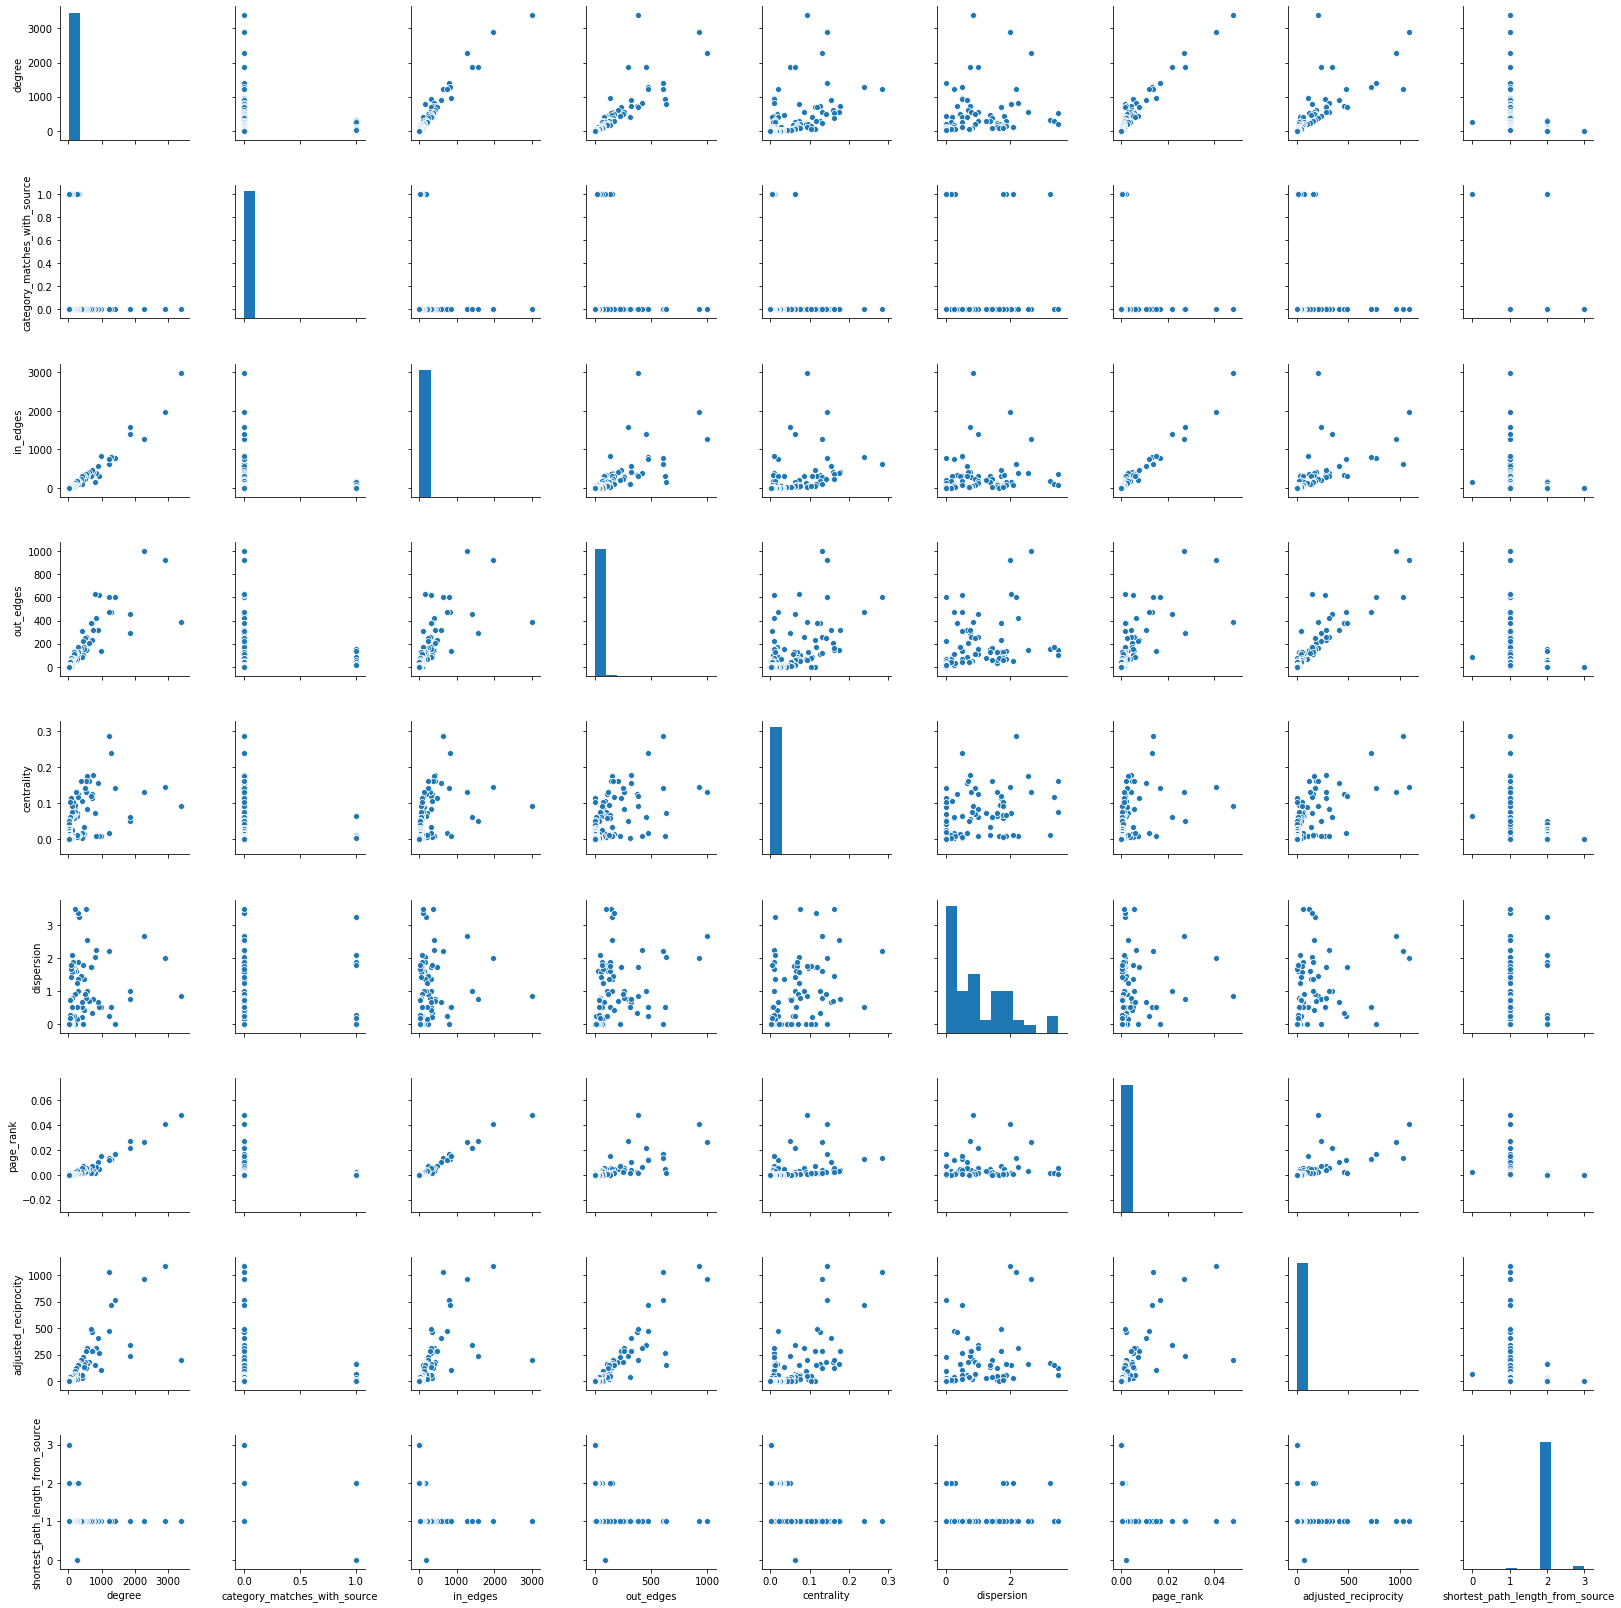

In [122]:
sns.pairplot(features_df)

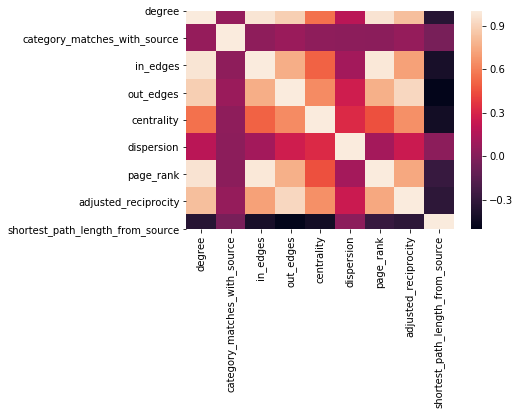

In [123]:
sns.heatmap(features_df.corr())

# Intro Node Values

In [136]:
intro_nodes = gc.intro_nodes
intro_nodes_df = None
for node in intro_nodes:
    if df is None:
        intro_nodes_df = pd.DataFrame(features_df[features_df.node == node])
    else:
        intro_nodes_df = pd.concat([intro_nodes_df, pd.DataFrame(features_df[features_df.node == node])])
    
intro_nodes_df

,node,degree,category_matches_with_source,in_edges,out_edges,centrality,dispersion,page_rank,adjusted_reciprocity,shortest_path_length_from_source
25,Decision support system,471,0,321.0,150.0,0.035093,1.375000,0.005049,132.0,1.0
30,Tree (graph theory),399,0,314.0,85.0,0.018070,0.666667,0.005783,56.0,1.0
64,Causal model,89,0,14.0,75.0,0.009283,1.666667,0.000241,4.0,1.0
3,Probability,1865,0,1571.0,294.0,0.050390,0.750000,0.027181,238.0,1.0
8,Utility,1223,0,746.0,477.0,0.018299,0.250000,0.011692,472.0,1.0
0,Algorithm,3378,0,2990.0,388.0,0.092462,0.857143,0.048187,204.0,1.0
4,Operations research,1856,0,1401.0,455.0,0.062521,1.000000,0.021576,338.0,1.0
53,Decision analysis,119,1,70.0,49.0,0.010685,2.100000,0.000933,28.0,2.0
27,Goal,426,0,326.0,100.0,0.006703,1.800000,0.004994,34.0,1.0
32,Decision tree learning,328,1,172.0,156.0,0.011569,3.250000,0.001664,174.0,2.0


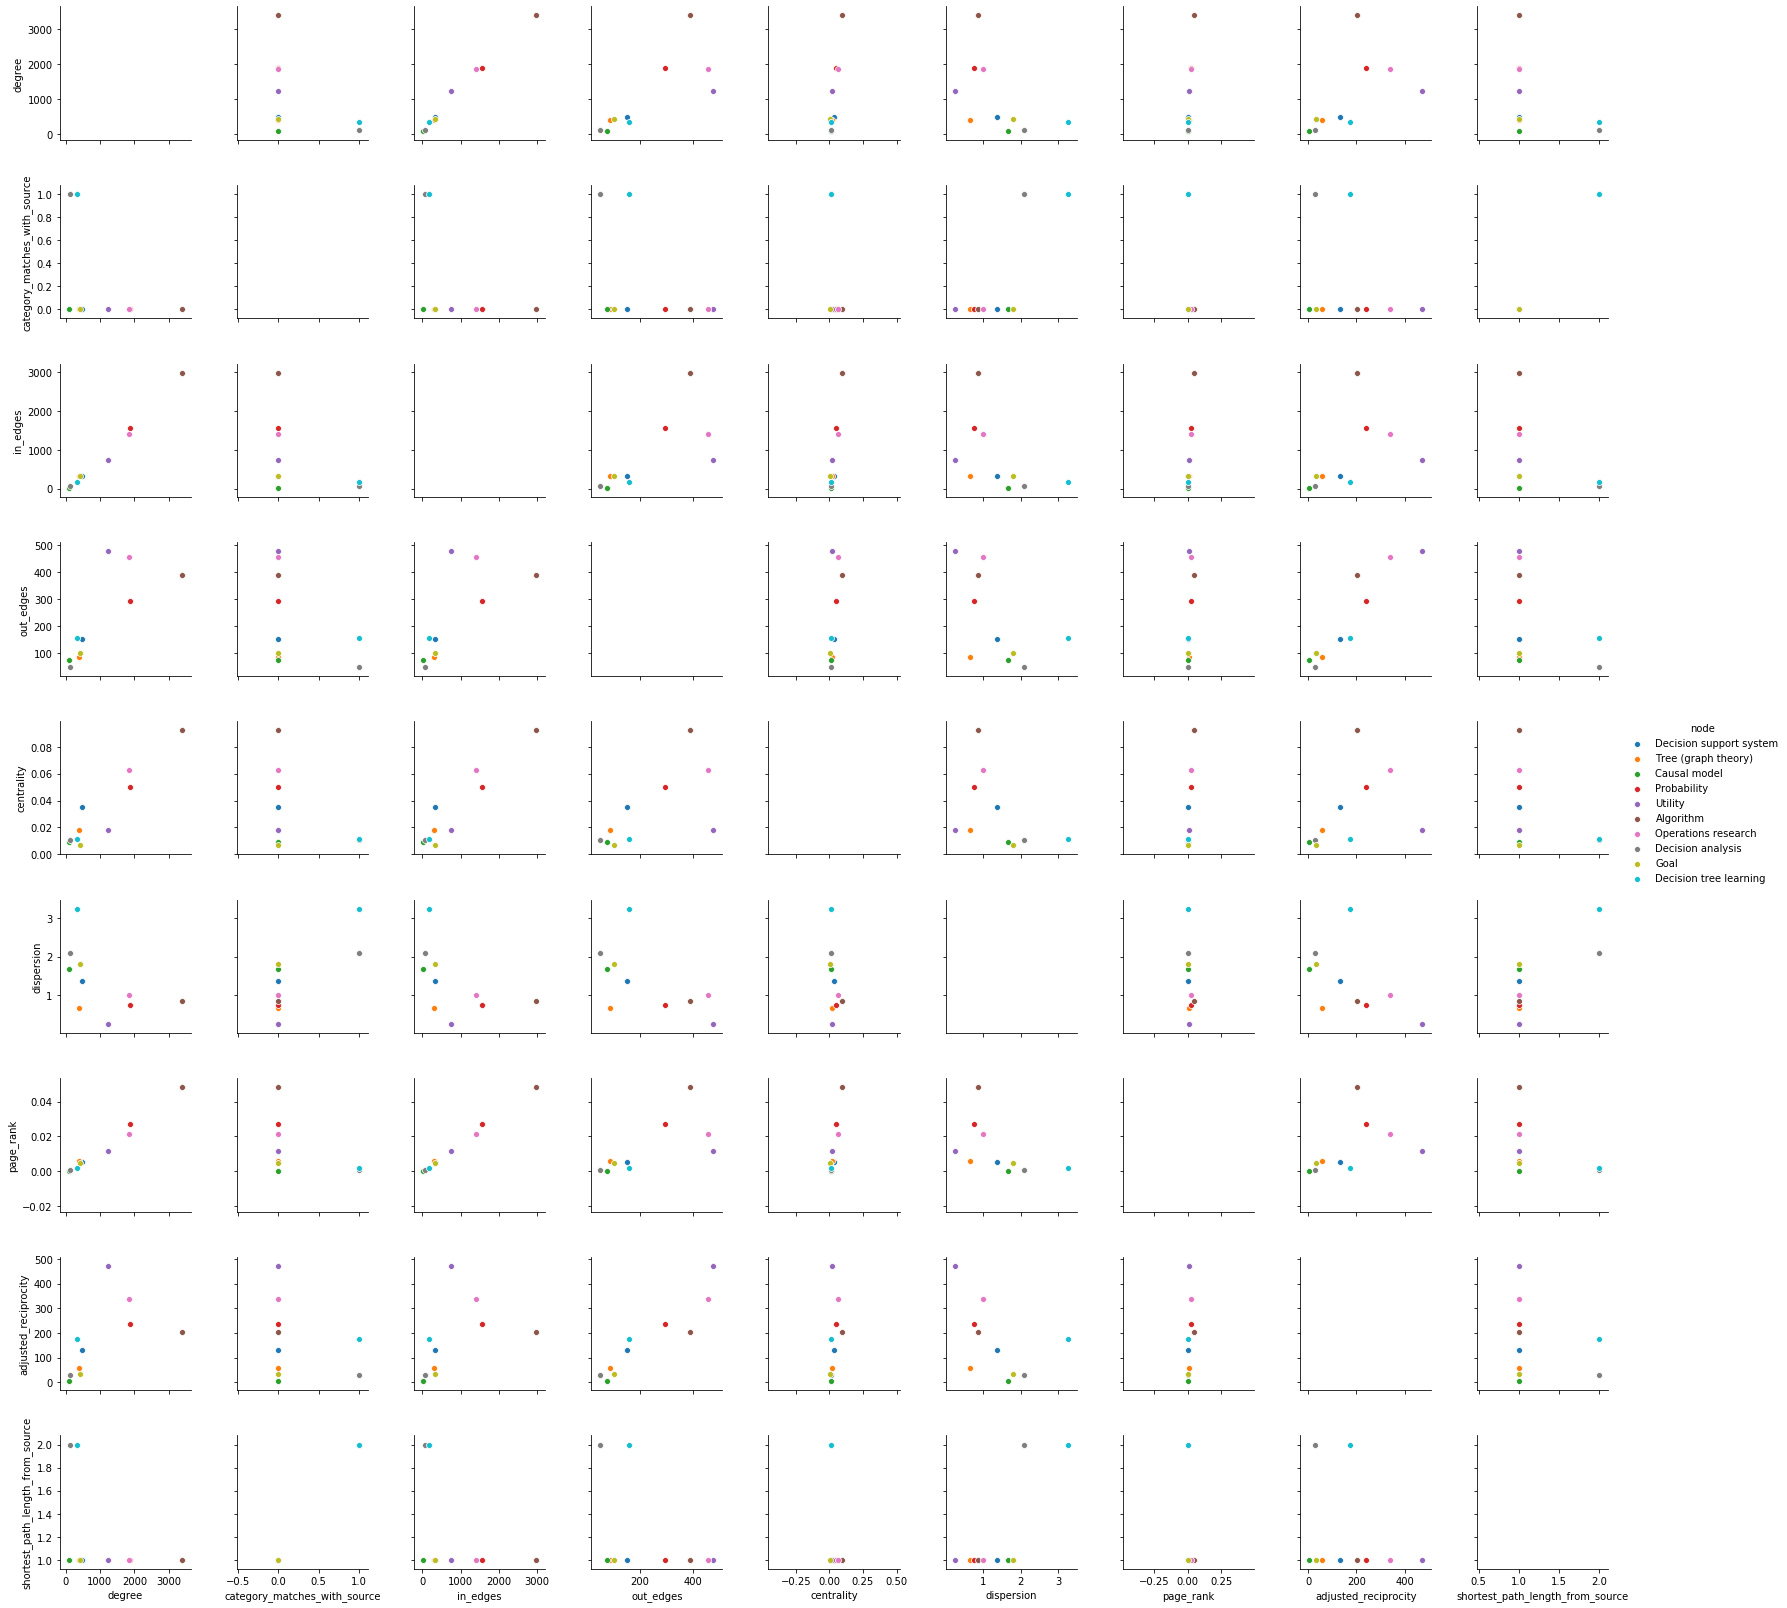

In [138]:
sns.pairplot(intro_nodes_df, hue="node")